# [4] 지역별 배송지연 원인 분석

## 1) RJ 지역의 배송지연 원인분석

In [ ]:
# RJ 지역 데이터 추출
raw_RJ = raw[raw['customer_state'] == 'RJ']
raw_RJ.shape

(15518, 38)

### (1) 시계열 분석


#### a. 월별 배송 지연율 : 최종 도착일 기준

In [ ]:
# 월별 컬럼 생성 : delivered_month
raw_RJ['delivered_month'] = raw_RJ['order_delivered_customer_date'].dt.strftime('%Y-%m')

# 월별 지연률 계산 (is_delayed 평균) : monthly_delay
monthly_delay = raw_RJ.groupby('delivered_month')['is_delayed'].mean().reset_index()

# 지연률을 %로 변환
monthly_delay['delay_percent'] = monthly_delay['is_delayed'] * 100
monthly_delay

/tmp/ipython-input-41-55292839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_RJ['delivered_month'] = raw_RJ['order_delivered_customer_date'].dt.strftime('%Y-%m')


,delivered_month,is_delayed,delay_percent
0,2016-10,0.000000,0.000000
1,2016-11,0.000000,0.000000
2,2017-01,0.000000,0.000000
3,2017-02,0.007663,0.766284
4,2017-03,0.026316,2.631579
5,2017-04,0.055749,5.574913
6,2017-05,0.056693,5.669291
7,2017-06,0.036325,3.632479
8,2017-07,0.031034,3.103448
9,2017-08,0.026201,2.620087


##### 시각화

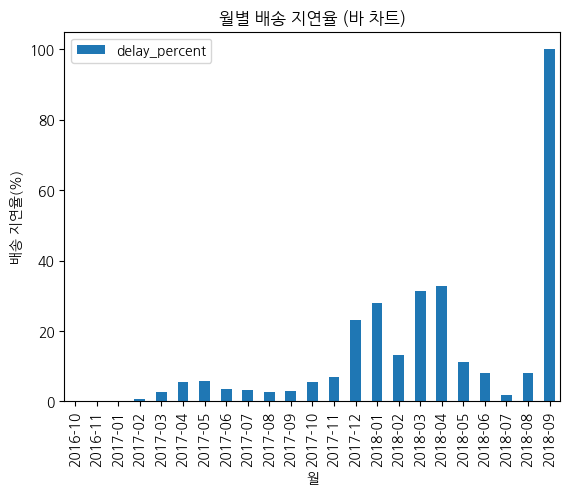

In [ ]:
# bar 차트 > 2018년 9월에 무슨일이?
monthly_delay.plot(kind = 'bar', x = 'delivered_month', y = 'delay_percent')
plt.xlabel("월")
plt.ylabel("배송 지연율(%)")
plt.title("월별 배송 지연율 (바 차트)");

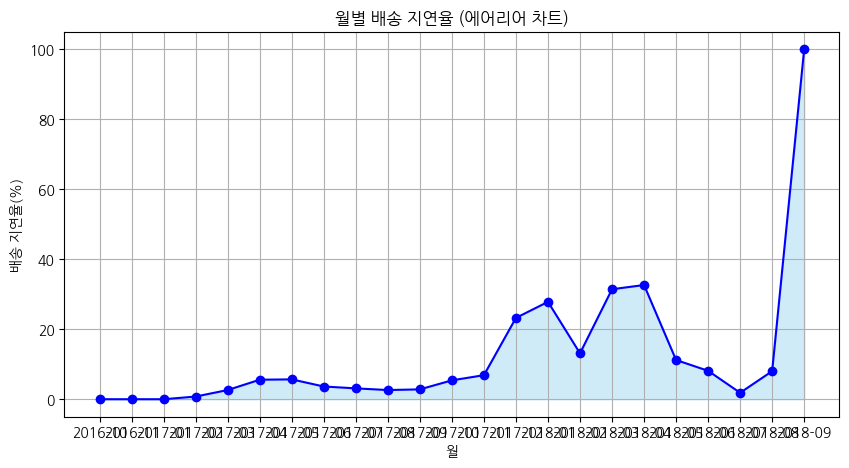

In [ ]:
# 에어리어 차트
import matplotlib.pyplot as plt

months = monthly_delay['delivered_month']
delay = monthly_delay['delay_percent']

plt.figure(figsize=(10, 5))
plt.fill_between(months, delay, color="skyblue", alpha=0.4)
plt.plot(months, delay, color="blue", marker='o')
plt.xlabel("월")
plt.ylabel("배송 지연율(%)")
plt.title("월별 배송 지연율 (에어리어 차트)")
plt.grid(True)
plt.show();

#### b. 월별 배송 지연율 : 주문일 기준 지연율

> 도착일을 기준으로 하는 데이터는 무의미, 주문일을 기준으로 지연율 분석

2018.09 지연율 데이터 = 주문은 다 8월에 이루어졌으나, 배송 도착일만 9월이라 지연율이 100%로 나옴


In [ ]:
# 연도, 주차 컬럼 생
raw_RJ['year'] = raw_RJ['order_delivered_customer_date'].dt.isocalendar().year
raw_RJ['week'] = raw_RJ['order_delivered_customer_date'].dt.isocalendar().week
raw_RJ['month'] = raw_RJ['order_delivered_customer_date'].dt.strftime('%Y-%m')

# 주문 일자 확인 > 사실상 주문은 다 8월에 이루어졌으나, 배송 도착일만 9월이라 지연률 100%로 나옴
raw_RJ.groupby('month')['order_approved_at'].agg(['min','max']).tail()

/tmp/ipython-input-44-1472222378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_RJ['year'] = raw_RJ['order_delivered_customer_date'].dt.isocalendar().year
/tmp/ipython-input-44-1472222378.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_RJ['week'] = raw_RJ['order_delivered_customer_date'].dt.isocalendar().week
/tmp/ipython-input-44-1472222378.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,min,max
month,,
2018-05,2017-11-25 23:59:27,2018-05-27 09:50:26
2018-06,2018-03-15 11:29:14,2018-06-27 11:06:50
2018-07,2018-04-24 17:45:41,2018-07-28 23:31:04
2018-08,2018-06-05 19:13:46,2018-08-29 08:30:21
2018-09,2018-02-23 15:16:14,2018-08-17 03:30:00


In [ ]:
# 주문월 컬럼 생성
raw_RJ['order_month'] = raw_RJ['order_purchase_timestamp'].dt.strftime('%Y-%m')

# 주문월 기준으로 그룹화 및 지연율 계산
monthly_delay_by_order = (raw_RJ.groupby('order_month')['is_delayed'].mean().reset_index())
monthly_delay_by_order['delay_rate'] = monthly_delay_by_order['is_delayed'] * 100

/tmp/ipython-input-45-506386482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_RJ['order_month'] = raw_RJ['order_purchase_timestamp'].dt.strftime('%Y-%m')


In [ ]:
monthly_delay_by_order

,order_month,is_delayed,delay_rate
0,2016-10,0.000000,0.000000
1,2017-01,0.036232,3.623188
2,2017-02,0.032468,3.246753
3,2017-03,0.046709,4.670913
4,2017-04,0.074813,7.481297
5,2017-05,0.026534,2.653400
6,2017-06,0.033755,3.375527
7,2017-07,0.030000,3.000000
8,2017-08,0.028107,2.810651
9,2017-09,0.053846,5.384615


In [ ]:
# 2018년 9, 10월 제거
monthly_delay_by_order = monthly_delay_by_order[~monthly_delay_by_order['order_month'].isin(['2018-09', '2018-10'])]

##### 시각화 ★

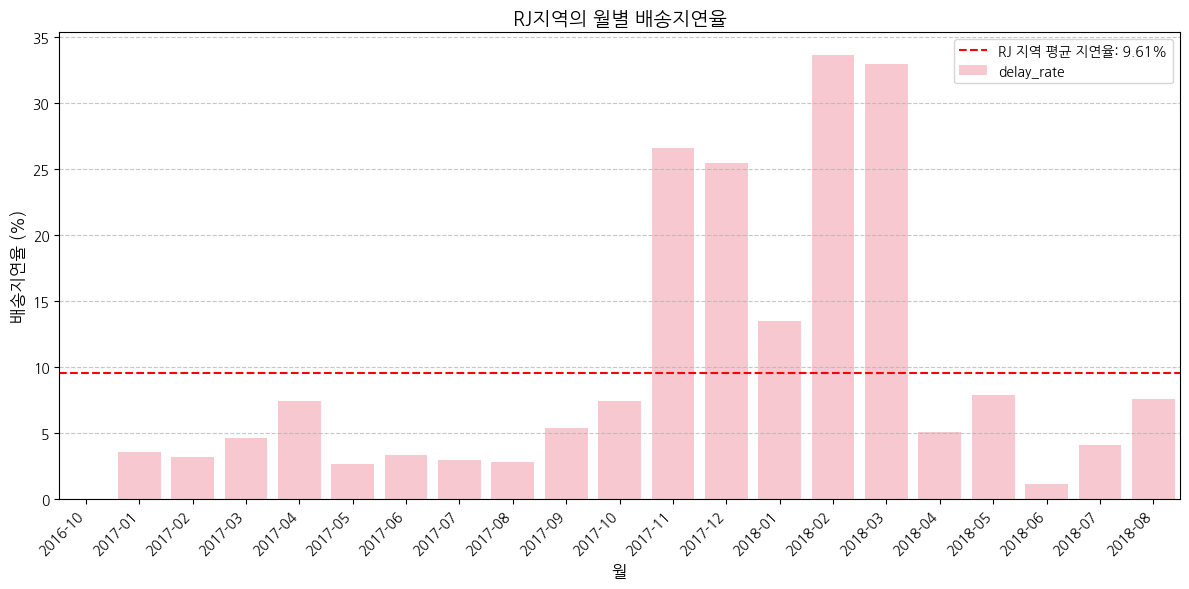

In [ ]:
# 평균 계산
average_delay = monthly_delay_by_order['delay_rate'].mean()

# 시각화
plt.figure(figsize=(12, 6))

# 막대그래프: 막대 간격은 Seaborn이 자동으로 균일하게 조절
sns.barplot(data=monthly_delay_by_order, x='order_month', y='delay_rate', color='pink', label='delay_rate')

# 평균선
plt.axhline(average_delay, color='red', linestyle='--', linewidth=1.5, label=f'RJ 지역 평균 지연율: {average_delay:.2f}%')

# 제목, 축 레이블, 범례 등 설정
plt.title('RJ지역의 월별 배송지연율', fontsize=14)
plt.xlabel('월', fontsize=12)
plt.ylabel('배송지연율 (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show();

###### [분석결과]

> 계절적 요인이 큰 영향

- 11~3월이 여름철로, 집중호우 및 홍수 위험이 높아 물류에 영향이 있음




### (2) 배송 단계별 분석

> 보유 데이터 : 결제 승인일, 물류사 도착일, 소비자 수령일

- 1구간 : 물류사 도착일 - 결제 승인일

- 2구간 : 소비자 수령일 - 물류사 도착일



#### a. 단계별 리드타임 ★

In [ ]:
# 단계별 소요시간 계산
raw_RJ['days_approved_to_carrier'] = (raw_RJ['order_delivered_carrier_date'] - raw_RJ['order_approved_at']).dt.days
raw_RJ['days_carrier_to_customer'] = (raw_RJ['order_delivered_customer_date'] - raw_RJ['order_delivered_carrier_date']).dt.days

/tmp/ipython-input-56-3195079918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_RJ['days_approved_to_carrier'] = (raw_RJ['order_delivered_carrier_date'] - raw_RJ['order_approved_at']).dt.days
/tmp/ipython-input-56-3195079918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_RJ['days_carrier_to_customer'] = (raw_RJ['order_delivered_customer_date'] - raw_RJ['order_delivered_carrier_date']).dt.days


#### 시각화 : 박스플롯, 바플롯

#### b. 전체 평균 리드타임 비교 ★

In [ ]:
# 시간데이터 변경
delivered['order_delivered_carrier_date'] = pd.to_datetime(delivered['order_delivered_carrier_date'])
delivered['order_delivered_customer_date'] = pd.to_datetime(delivered['order_delivered_customer_date'])
delivered['order_approved_at'] = pd.to_datetime(delivered['order_approved_at'])


# 전체지역 리드타임 생성
delivered['days_approved_to_carrier'] = (delivered['order_delivered_carrier_date'] - delivered['order_approved_at']).dt.days
delivered['days_carrier_to_customer'] = (delivered['order_delivered_customer_date'] - delivered['order_delivered_carrier_date']).dt.days


# 전체지역 평균
total_means = {'승인→운송사': delivered['days_approved_to_carrier'].mean(),
    '운송사→고객': delivered['days_carrier_to_customer'].mean(),}
total_means


{'승인→운송사': np.float64(2.3477779890411905),
 '운송사→고객': np.float64(8.746824066232262)}

In [ ]:
# RJ 지역 평균
RJ_means = {'승인→운송사': raw_RJ['days_approved_to_carrier'].mean(), '운송사→고객': raw_RJ['days_carrier_to_customer'].mean(),}

# 비교 데이터 프레임
comparison_df = pd.DataFrame({'단계': total_means.keys(), '전체 평균': total_means.values(), 'RJ 평균': RJ_means.values()})
comparison_df

,단계,전체 평균,RJ 평균
0,승인→운송사,2.347778,2.515648
1,운송사→고객,8.746824,11.383135


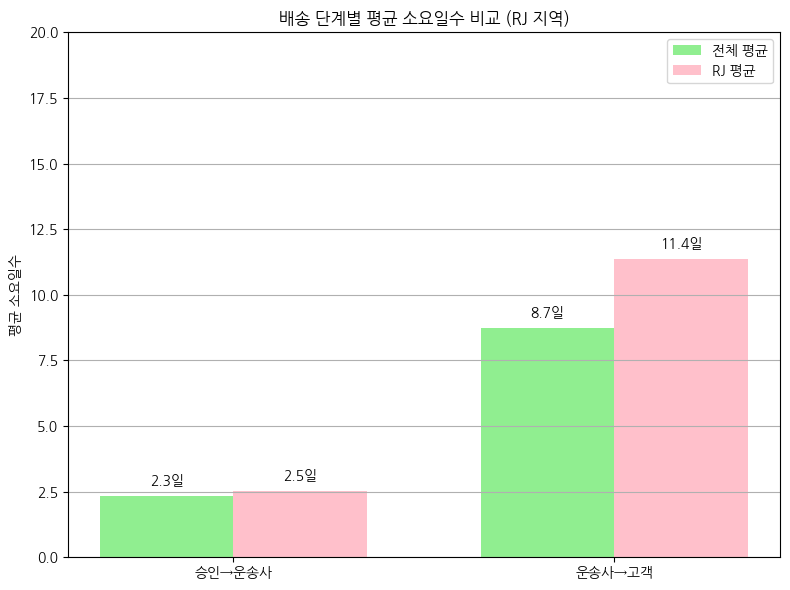

In [ ]:
# 시각화
x = comparison_df['단계']
total = comparison_df['전체 평균']
rj_avg = comparison_df['RJ 평균']

plt.figure(figsize=(8, 6))
bar_width = 0.35
index = range(len(x))

bars1 = plt.bar(index, total, bar_width, label='전체 평균', color='lightgreen')
bars2 = plt.bar([i + bar_width for i in index], rj_avg, bar_width, label='RJ 평균', color='pink')

plt.xticks([i + bar_width / 2 for i in index], x)
plt.ylabel('평균 소요일수')
plt.title('배송 단계별 평균 소요일수 비교 (RJ 지역)')
plt.ylim([0, 20])
plt.legend()
plt.grid(axis='y')

for i in range(len(index)):
    plt.text(index[i], total[i] + 0.3, f'{total[i]:.1f}일', ha='center', va='bottom', fontsize=10)
    plt.text(index[i] + bar_width, rj_avg[i] + 0.3, f'{rj_avg[i]:.1f}일', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show();

### 리우데자네이루(RJ)지역 인사이트(하선혜)

> 시계열 데이터 : 계절적 요인이 큰 원인

2017년 11월부터 2018년 3월 사이의 월간 배송지연율이 2개년 평균 지연율(8.77%)에 비해 월등히 높음

* 리우데자네이루가 포함된 브라질 남동부 지역은 11~2월이 우기로, 이 시기에 집중 호우와 홍수가 빈번하게 발생함

* 실제로 2017년 11월~2018년 3월 기간 동안 평균 380mm의 강수량 기록

계절적 요인은 지속적으로 반복되는 문제로, 시스템적 개선 필요


> 배송 단계별 리드타임 : 유통업체(물류 파트너)에서 최종 소비자까지의 배송 단계에서 병목현상 발생

Olist는 직접 배송이 아닌, 다양한 외부 물류 파트너사를 통해 배송하는 방식
→ 직접적인 물류 프로세스 개선은 해당 없음


> 개선 방향 : 물류 파트너 인센티브제 도입, 물류 파트너 다변화

특정 시기와 특정 단계에서 배송 지연율이 높아지는 것은 일회성 이벤트가 아닌 시스템적 문제로 개선이 필요함
* 물류 파트너사에서 최종 소비자까지의 배송 단계에서 발생하는 병목 현상 해결 필요

**해결방안** : 물류 파트너사에 대한 관리 강화

1. 물류 파트너사 인센티브제 도입
* 배송 지연율을 낮게 유지하는 파트너사에 인센티브 제공
 * 예) 시스템 배송 예상일보다 배송기간을 단축한 운송 파트너사에 추가 배송료 지급
2. 운송방법 다각화
* 파트너사 확대
* 현재는 주로 도로(트럭)를 이용하고 있으며, 특정 시기별 병목 현상 해결을 위해 항공, 철도 등 운송 방법 자체의 다각화가 필요






